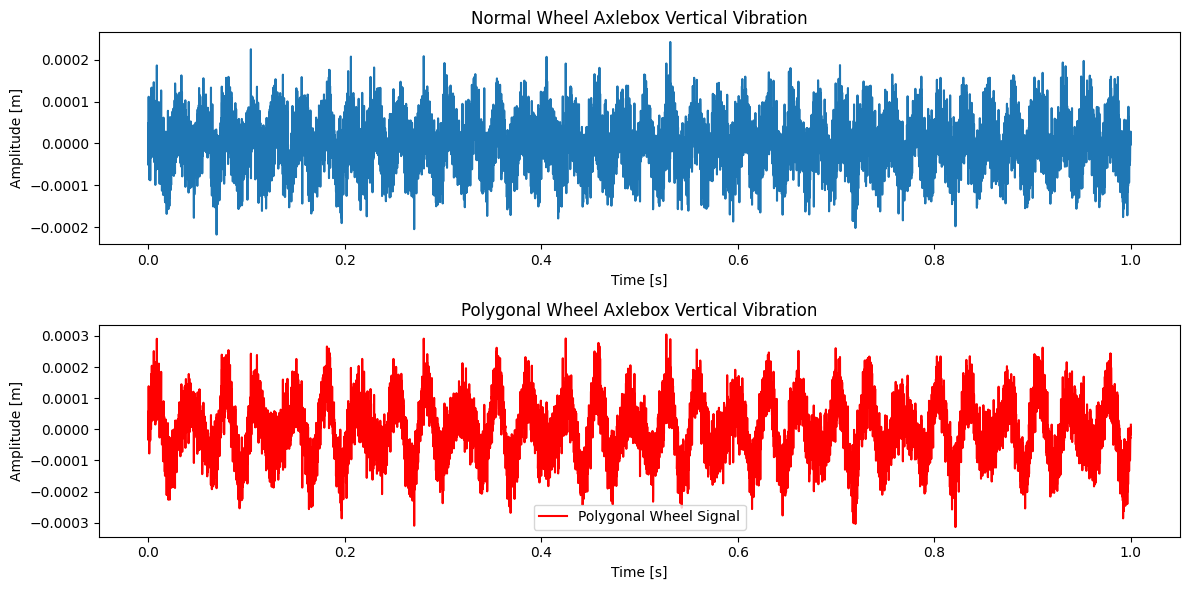

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 定义参数
fs = 10000  # 采样频率，单位：Hz
T = 1.0     # 仿真时间，单位：s
N = int(fs * T)  # 总采样点数
t = np.linspace(0, T, N)  # 时间序列

# 车速和车轮半径
v = 300 / 3.6  # 车速，单位：m/s
R = 0.458  # 车轮半径，单位：m

# 振动参数
f1 = 28.96  # Hz
omega1 = 2 * np.pi * f1
A1 = 0.0001  # m
f2 = 579.17  # Hz
omega2 = 2 * np.pi * f2
A2 = 0.00002  # m
f3 = 40.00  # Hz
omega3 = 2 * np.pi * f3
A3 = 0.00005  # m

# 白噪声的RMS幅值
A_noise = 0.00005

# 计算白噪声的方差
variance_noise = A_noise**2

# 生成白噪声信号
noise = np.sqrt(variance_noise) * np.random.normal(0, 1, N)

# 生成仿真信号
y_normal = A3 * np.sin(omega3 * t) + noise  # 正常车轮信号，仅包含P2振动
y_polygon = A1 * np.sin(omega1 * t) + A2 * np.sin(omega2 * t) + A3 * np.sin(omega3 * t) + noise  # 多边形车轮信号

# 绘制时域图
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, y_normal, label='Normal Wheel Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [m]')
plt.title('Normal Wheel Axlebox Vertical Vibration')

plt.subplot(2, 1, 2)
plt.plot(t, y_polygon, label='Polygonal Wheel Signal', color='red')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [m]')
plt.title('Polygonal Wheel Axlebox Vertical Vibration')

plt.legend()
plt.tight_layout()
plt.show()

In [18]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.signal import hilbert
from scipy.fft import fft
from sklearn.model_selection import train_test_split
import pandas as pd
from PyEMD import EEMD

# 定义参数
fs = 5000  # 采样频率，单位：Hz
T = 2.0     # 仿真时间，单位：s
N = int(fs * T)  # 总采样点数
t = np.linspace(0, T, N)  # 时间序列

# 车速和车轮半径
v = 300 / 3.6  # 车速，单位：m/s
R = 0.458  # 车轮半径，单位：m

# 振动参数
f1 = 28.96  # Hz
omega1 = 2 * np.pi * f1
A1 = 0.0001  # m
f2 = 579.17  # Hz
omega2 = 2 * np.pi * f2
A2 = 0.00002  # m
f3 = 40.00  # Hz
omega3 = 2 * np.pi * f3
A3 = 0.00005  # m

# 白噪声的RMS幅值
A_noise = 0.00005

# 计算白噪声的方差
variance_noise = A_noise**2

# 生成白噪声信号
noise = np.sqrt(variance_noise) * np.random.normal(0, 1, N)

# 生成仿真信号
y_normal = A3 * np.sin(omega3 * t) + noise  # 正常车轮信号，仅包含P2振动
y_polygon = A1 * np.sin(omega1 * t) + A2 * np.sin(omega2 * t) + A3 * np.sin(omega3 * t) + noise  # 多边形车轮信号

In [19]:
# 1. MEEMD分解
def meemd_decomposition(t, signal, emd, noise_level=0.2, num_imfs=5):
    """
    对信号进行MEEMD分解，并返回前num_imfs个IMF分量。
    """
    if signal.std() == 0:
        raise ValueError("信号的标准差为0，无法生成白噪声。")

    # 生成白噪声
    noise = np.random.randn(len(signal)) * signal.std() * noise_level

    # 添加白噪声
    signal_plus = signal + noise
    signal_minus = signal - noise

    # EMD分解
    imfs_plus = emd(signal_plus, t)
    imfs_minus = emd(signal_minus, t)

    # 确保imfs_plus和imfs_minus至少有num_imfs个分量
    num_imfs_actual = min(len(imfs_plus), len(imfs_minus), num_imfs)

    # 集合平均
    imfs = []
    for i in range(num_imfs_actual):
        imf_plus = imfs_plus[i]
        imf_minus = imfs_minus[i]
        imfs.append(np.mean([imf_plus, imf_minus], axis=0))

    return imfs

# 2. IMF分量筛选
def select_main_imfs(imfs):
    """
    根据IMF分量的峭度和能量值筛选出主要IMF分量。
    """
    kurtosis_values = [np.mean(np.abs(imf - np.mean(imf))**4) / np.mean(np.abs(imf - np.mean(imf))**2)**2 for imf in imfs]
    energy_values = [np.sum(imf**2) for imf in imfs]
    main_imfs = [imfs[i] for i in range(len(imfs)) if kurtosis_values[i] > 3 and energy_values[i] > np.mean(energy_values)]
    return main_imfs

# 3. 包络谱熵计算
def envelope_spectrum_entropy(imf):
    """
    计算IMF分量的包络谱熵。
    """
    # 希尔伯特变换
    analytic_signal = hilbert(imf)
    # 包络信号
    envelope = np.abs(analytic_signal)
    # FFT变换
    spectrum = fft(envelope)
    # 归一化频谱
    normalized_spectrum = spectrum / np.sum(np.abs(spectrum))
    # 计算信息熵
    entropy = -np.sum(normalized_spectrum * np.log2(normalized_spectrum))
    return entropy

def calculate_features_imfs(imfs):
    # 使用NumPy的向量化操作计算所有IMFs的包络谱熵
    analytic_signals = np.abs(hilbert(imfs))
    spectrum = fft(analytic_signals)
    normalized_spectrum = spectrum / np.sum(np.abs(spectrum))
    entropy = -np.sum(normalized_spectrum * np.log2(normalized_spectrum + 1e-10))  # 防止log(0)
    return entropy

# 4. GA-SVM识别
def train_and_test_ga_svm(features_train, labels_train, features_test, labels_test):
    """
    使用GA-SVM进行训练和测试。
    """
    
    # 归一化特征
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_test = scaler.transform(features_test)
    # 设置SVM参数
    svm = SVC(kernel='rbf', C=1.0)
    # 遗传算法参数寻优
    param_grid = {'C': np.logspace(-3, 3, 7), 'gamma': np.logspace(-3, 3, 7)}
    grid_search = GridSearchCV(svm, param_grid, cv=5)
    grid_search.fit(features_train, labels_train)
    # 测试
    accuracy = grid_search.score(features_test, labels_test)
    return accuracy

In [ ]:
emd = EEMD()
def dataset(t, signal, label, window_size, step_size):
    features_list = []
    labels_list = []
    for i in range(0, len(signal) - window_size + 1, step_size):
        t_seq = t[i:i + window_size]
        seq = signal[i:i + window_size]
        imfs = meemd_decomposition(t_seq, seq, emd)
        main_imfs = select_main_imfs(imfs)
        for imf in main_imfs:
            feature_value = calculate_features_imfs(imf)
            features = features.append(pd.DataFrame([feature_value], columns=['Envelope_Spectrum_Entropy']), ignore_index=True)
    features_df = pd.DataFrame(features_list, columns=['Envelope_Spectrum_Entropy'])
    labels_df = pd.DataFrame(labels_list, columns=['label'])
    return features_df, labels_df

features_normal,labels_normal = dataset(t,y_normal,0,1000,100)
features_polygon,labels_polygon = dataset(t,y_polygon,1,1000,100)
features_dataset = pd.concat([features_normal,features_polygon],ignore_index=True)
labels_dataset = pd.concat([labels_normal,labels_polygon],ignore_index=True)
features_train, features_test, labels_train, labels_test = train_test_split(
    features_dataset,
    labels_dataset,
    test_size=0.2,  # 20%的数据用作测试集
    random_state=42,  # 设置随机种子
    stratify=labels_dataset['label']
)

accuracy = train_and_test_ga_svm(features_train, labels_train, features_test, labels_test)
print("识别准确率:", accuracy)